[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhillySchoolofAI/deepdream/blob/master/deepdream.ipynb)

# DeepDreaming with TensorFlow

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

### 1) Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [1]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
file_contents = open("pilatus800.jpg").read() 

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2018-10-18 14:00:16--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   115MB/s    in 0.4s    

2018-10-18 14:00:17 (115 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
--2018-10-18 14:00:19--  https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... c

### Optional: Upload an image from your computer

# Skip these steps if you just want to run this example

In [4]:
from google.colab import files
uploaded = files.upload()

Saving fullsizeoutput_1.jpeg to fullsizeoutput_1.jpeg


In [0]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[uploaded.keys()[0]]

### 2) Load the starting image 

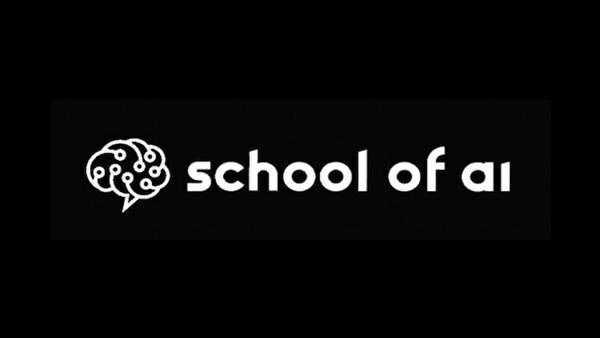

In [7]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### 4) The core deepdream code

In [0]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### 4) Let's deep dream !

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

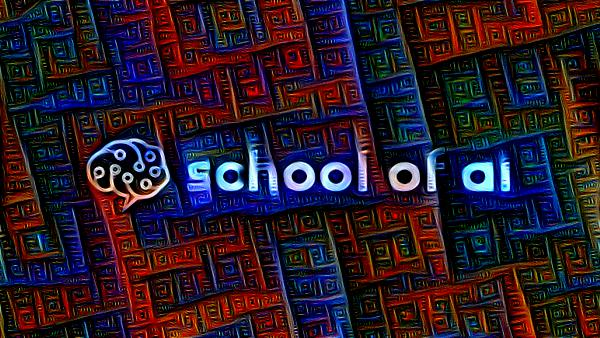

In [17]:
octave_n = 10 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 50 #@param {type:"slider", max: 50}
strength = 233 #@param {type:"slider", max: 1000}
layer = "mixed3a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)


### 5) Individual neurons

We can also try and optimize not against an entire layer but just one neuron's activity:

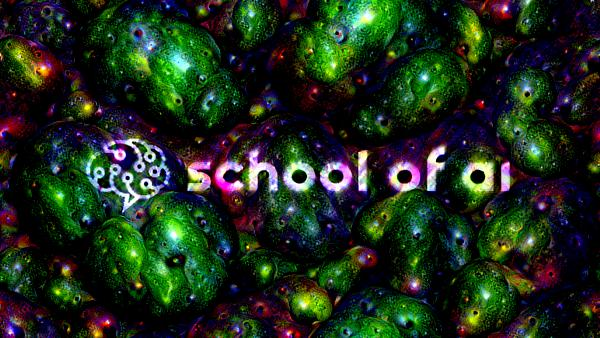

In [21]:
feature_channel = 154 #@param {type:"slider", max: 512}
layer = "mixed4c"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)

### 6) Zooming iterative DeepDream

We can enter completely immersive worlds by iteratively sooming into the picture:

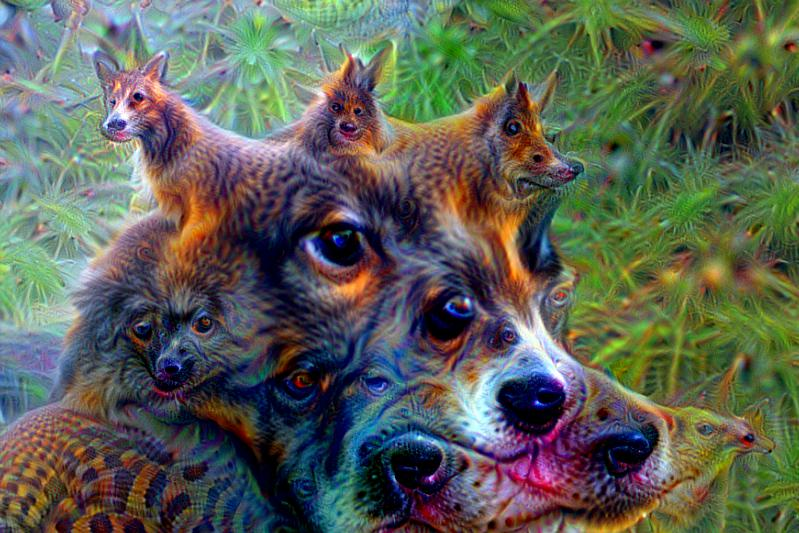

In [0]:
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 5 #@param {type:"slider", max: 50}
strength = 150 #@param {type:"slider", max: 1000}
zooming_steps = 20 #@param {type:"slider", max: 512}
zoom_factor = 1.1 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe

## 7) Diving deeper into the Inception Model

Lets look a bit deeper into the Inception Model and visualize the layers. Each layer will produce a very different result when used in deep dreaming.

In [0]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

For example try deepdreaming with the layer '`mixed4a_3x3_pre_relu`'

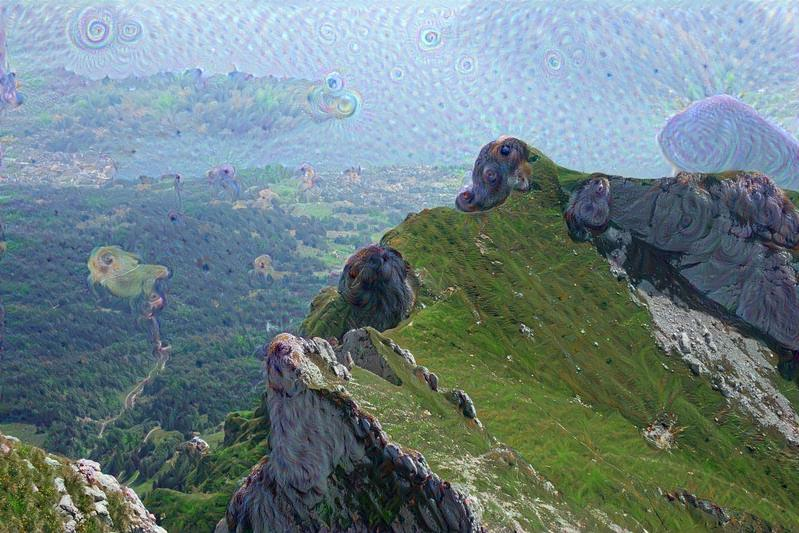

In [0]:
layer = "mixed4a_3x3_pre_relu"
final = render_deepdream(tf.square(T(layer)), img0)

We can also use TensorBoard to visualize the full graph to understand bettter how these different layers relate to each other. Most of the code in the next section just makes the graph look a little bit cleaner.

In [0]:

# Helper functions for TF Graph visualization
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)